In [33]:
import pandas as pd 
import math
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from numpy import interp
from sklearn import preprocessing,manifold
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split, StratifiedKFold

In [2]:
#Reading the data
#   data = pd.read_csv("mfccToy2.csv",header=None)
data = pd.read_csv("mfcc.csv",header=None)
data = pd.DataFrame(data).to_numpy()
data.shape

(1868, 86)

In [3]:
data = data[~np.isnan(data).any(axis=1)]
data.shape

target = data[:,-2]
X = data[:,:-2]
order = data[:,-1]
order = order.reshape(order.shape[0],1)
X_norm = (X-X.min(axis=0))/(X.max(axis=0)-X.min(axis=0))
print(data.shape,X.shape,order.shape)
X_complete = np.concatenate((X_norm, order), axis=1)

(1353, 86) (1353, 84) (1353, 1)


In [39]:
# This function plots the 2 dimensional data with the target colors
def plot_emotions(Xe,target,pred,title):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.title.set_text('Real')
    ax2.title.set_text('Predicted')
    ax1.scatter(Xe[target==1,0],Xe[target==1,1],c="yellow",label="happy")
    ax1.scatter(Xe[target==0,0],Xe[target==0,1],c="black",label="sad")
    ax2.scatter(Xe[pred==1,0],Xe[pred==1,1],c="yellow",label="happy")
    ax2.scatter(Xe[pred==0,0],Xe[pred==0,1],c="black",label="sad")
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center')
    fig.set_size_inches(10, 5, forward=True)
    fig.suptitle(title)
    plt.show()

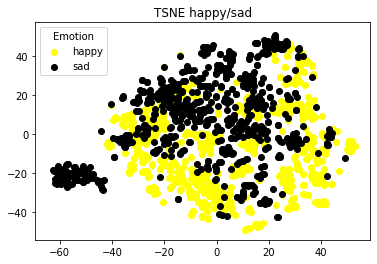

In [6]:
Xe= manifold.TSNE( metric='euclidean', method='barnes_hut').fit_transform(X_norm)
fig,ax=plt.subplots()
ax.scatter(Xe[target==1,0],Xe[target==1,1],c="yellow",label="happy")
ax.scatter(Xe[target==0,0],Xe[target==0,1],c="black",label="sad")
plt.legend(loc='upper left',title="Emotion")
plt.title('TSNE happy/sad')
plt.show()

In [8]:
# Substravtive Clustering
def substractive(data,ra,norm):
    import numpy as np
    from math import exp
    m,n = data.shape[0], data.shape[1]
    rb = 1.5*ra
    D = np.zeros((m,1))

    # Compute first center
    for i in range(m):
        for j in range(n):
            D[i] += exp(-np.linalg.norm(data[i,:]-data[j,:],norm)/(ra/2)**2)
    
    val = max(D)
    idx = np.argmax(D)
    ma = val
    centers = data[idx,:]
    cen = 0

    # Compute all centers until all the data is within the influence range of a cluster center
    while( ma > rb ):
        center = centers[cen,:]
        for i in range(m):
            sum = 0
            for  j in range(m):
                sum += exp(-np.linalg.norm(data[i,:]-center,norm)/(rb/2)**2)
            D[i] -= ma*sum
        val = max(D)
        idx = np.argmax(D)
        ma = val
        centers.append(data[idx,:],axis = 0)
        cen += 1

    return centers

## Clustering Methods

In [32]:
ras = [1, 0.9, 0.8, 0.7]
results = np.empty((3,0))
for ra in ras:
    center_euclidean = substractive(data,ra,2)
    center_1norm = substractive(data,ra,1)
    center_infinity = substractive(data,ra,math.inf)
    results = np.append(results,[[center_euclidean.shape[0]],[center_1norm.shape[0]],[center_infinity.shape[0]]],axis = 1)
pd.DataFrame(data=results, index=["Euclidean", "Cityblock","Infinito"], columns=["r_a = 1","r_a = 0.9","r_a = 0.8"," r_a = 0.7"])

,r_a = 1,r_a = 0.7,r_a = 0.5,r_a = 0.3
Euclidean,86.0,86.0,86.0,86.0
Cityblock,86.0,86.0,86.0,86.0
Infinito,86.0,86.0,86.0,86.0


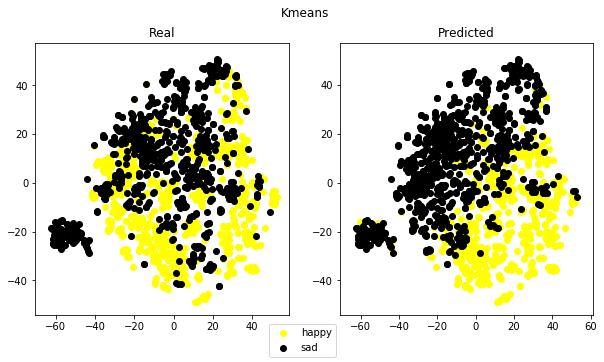

In [46]:
kmeans = KMeans(n_clusters=2).fit(X_norm)
plot_emotions(Xe,target,kmeans.labels_,"Kmeans")

## Objetivo:
Detectar las clasificaciones equivocadas en el plano feliz/triste y encontrar patrones de instrumentalidad

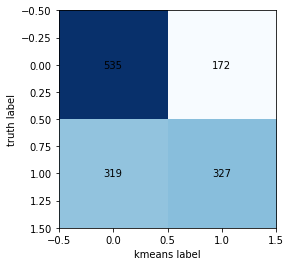

In [49]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(target,kmeans.labels_)
# Plot confusion matrix
plt.imshow(cm,interpolation='none',cmap='Blues')
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("kmeans label")
plt.ylabel("truth label")
plt.show()